In [189]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt

In [190]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
%autoreload 2

## Chargement des données

In [209]:
import emoncmsfeed as getfeeds

In [210]:
dataframefreq = '10min'
feeds =  { 'T_ext':2, 'T_int':3 }

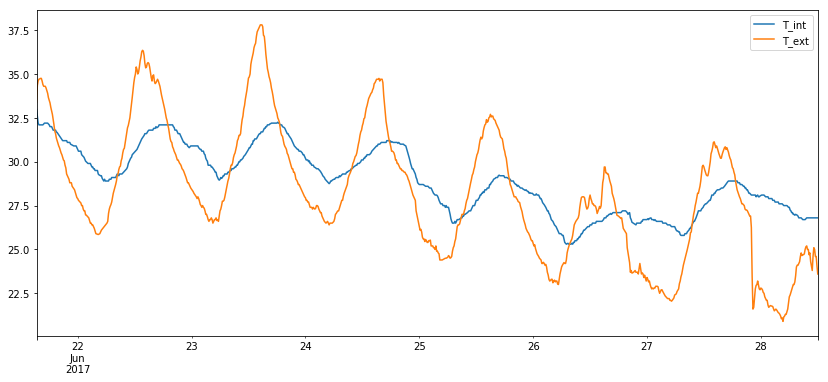

In [213]:
df = getfeeds.builddataframe( feeds, dataframefreq ) # startdate=pd.to_datetime('22/06/2017')
df.plot( figsize=(14, 6) );

In [196]:
# To array :
T_ext = df['T_ext'].as_matrix().flatten()
T_int = df['T_int'].as_matrix().flatten()

## Modèle linéaire simple (01)

$$
m.C_p \, \frac{dT}{dt} = S.h\,( T - T_{ext} )
$$

Avec $m.Cp$ la masse thermique, $S$ la surface avec l'extérieure et $h$ le coefficient d'échange

On pose:
$$
\beta = \frac{S.h}{m.C_p}
$$

et en pasant par les transformées de Fourier, on obtient: 
$$
\tilde T = \frac{\beta}{\beta + 2\pi i \, f } \tilde T_{ext}
$$

In [214]:
def model01_apply( beta,  T_ext ):
    
    # TF (reel)
    TF_ext = np.fft.rfft( T_ext  )
    freq = np.fft.rfftfreq( T_ext.size, d=1)
    
    freq = freq/( 10*60 )  # resample freq
    
    # modele
    TF_theo = beta/( beta + 2j*np.pi*freq )*TF_ext

    # TF inverse
    T_theo = np.fft.irfft( TF_theo , n=T_ext.size )
    
    return T_theo

In [215]:
from scipy.optimize import fmin

In [216]:
def errorfit( param, T_int, T_ext  ):
    T_theo = model01_apply( param, T_ext )
    return np.sum( (T_int - T_theo)**2 )
  

def model01_fit( T_int, T_ext ):
    
    betaZero = 3e-05

    res = fmin(errorfit, betaZero, disp=True, full_output =True, args=(T_int, T_ext))

    paramOpt, fopt = res[:2]

    print( paramOpt ) #  best_params )
    print( fopt )
    
    return paramOpt[0]

In [217]:
## beta : 2.65585250e-05

In [218]:
errorfit( 2.6e-5, T_int, T_ext  )

1009.5403591261858

In [219]:
best_beta = model01_fit( T_int, T_ext )

Optimization terminated successfully.
         Current function value: 873.582386
         Iterations: 11
         Function evaluations: 22
[  3.64570312e-05]
873.582385767


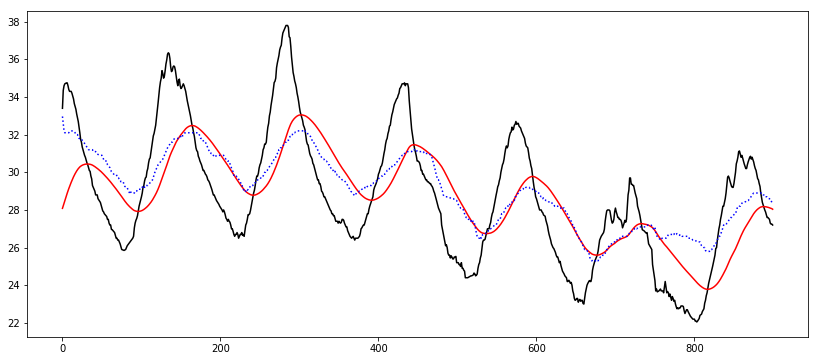

In [220]:
beta = best_beta  # 2.33e-05
T_theo = model01_apply( beta, T_ext )

plt.figure( figsize=(14, 6) )
plt.plot(T_ext, 'k')
plt.plot(T_theo, 'r')
plt.plot(T_int, ':b');

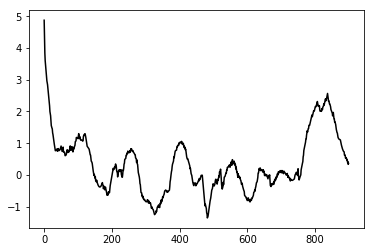

In [204]:
plt.plot(T_int-T_theo, 'k')

In [208]:
print( T_int.mean() )
print( T_ext.mean() )

29.0847499775
28.740162046


In [206]:
df['residus'] = T_int-T_theo

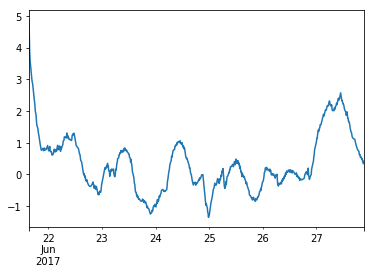

In [207]:
df['residus'].plot()

### prendre en compte l'irradiation solaire ... !